In [345]:
import os
import qubic
import healpy as hp
import numpy as np
import pylab as plt
import matplotlib as mpl
import sys
import glob
from pysimulators import FitsArray
from qubic import gal2equ
from Tools import QubicToolsJCH as qt
%matplotlib inline
rc('figure',figsize=(15,10))
rc('font',size=12)

Reads MC performed on Tycho fr testing SpectroImaging capabilities

In [346]:
rep = '/Users/hamilton/Qubic/SpectroImager/NewMC/OutRepMC/'
nsubvals = np.array([1,2,3,4,5])
filesin = []
filesout = []
filesnu = []
tolstr = '5e-5'
for i in xrange(len(nsubvals)):
    filesin.append(glob.glob(rep+'*'+tolstr+'*nf{}*maps_convolved.fits'.format(nsubvals[i])))
    filesout.append(glob.glob(rep+'*'+tolstr+'*nf{}*maps_recon.fits'.format(nsubvals[i])))
    filesnu.append(glob.glob(rep+'*'+tolstr+'*nf{}*nus.fits'.format(nsubvals[i])))
    print(nsubvals[i], len(filesin[i]), len(filesout[i]), len(filesnu[i]),)

(1, 20, 20, 20)
(2, 20, 20, 20)
(3, 20, 20, 20)
(4, 20, 20, 20)
(5, 20, 20, 20)


In [347]:
nside = 256
allmapsin = []
allmapsout = []
freqs = []
nmax = 20
for i in xrange(len(nsubvals)):
    fin = filesin[i][0:nmax]
    fout = filesout[i][0:nmax]
    fnu = filesnu[i][0:nmax]
    freqs.append(FitsArray(fnu[0]))
    mapsin = np.zeros((len(fin), nsubvals[i], 12*nside**2,3))
    mapsout = np.zeros((len(fout), nsubvals[i], 12*nside**2, 3))
    print('reading {}'.format(nsubvals[i]))
    for ifile in xrange(len(fin)):
        mapsin[ifile,:,:,:] = FitsArray(fin[ifile])
        mapsout[ifile,:,:,:] = FitsArray(fout[ifile])
    allmapsin.append(mapsin)
    allmapsout.append(mapsout)
    print(allmapsin[i].shape)

reading 1
(20, 1, 786432, 3)
reading 2


KeyboardInterrupt: 

In [113]:
for i in xrange(len(nsubvals)): print(allmapsout[i].shape)

(20, 1, 786432, 3)
(20, 2, 786432, 3)
(20, 3, 786432, 3)
(20, 4, 786432, 3)
(20, 5, 786432, 3)


0
1
2
3
4


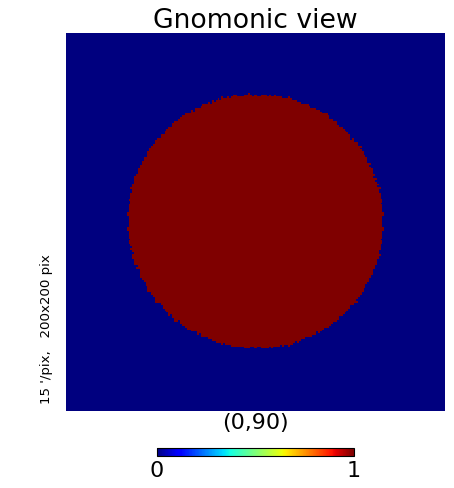

In [114]:
### Calculate seen pixels over the whole simulation
seenmap = np.zeros(12*nside**2) == 0
for i in arange(len(nsubvals)):
    dims = np.shape(allmapsin[i])
    print(i)
    for i0 in arange(dims[0]):
        for i1 in arange(dims[1]):
            for i3 in arange(dims[3]):
                seenmap *= allmapsin[i][i0,i1,:,i3] != hp.UNSEEN

hp.gnomview(seenmap, rot=[0,90], reso=15)
### Ip of the seen pixels
seen =  where(seenmap == 1)[0]

In [115]:
### Just look at direct Mean and RMS of pixels over 
### realizations as well as over the subfreqs. 
### In such a case one first
### averages over subfrequencies for a given realization, and the aveages over realizations

rmsmap = np.zeros((len(nsubvals),3,12*nside**2))+hp.UNSEEN
meanmap = np.zeros((len(nsubvals),3,12*nside**2))+hp.UNSEEN
for i in arange(len(nsubvals)):
    print(i)
    mapsout = allmapsout[i]
    for p in seen:
        for iqu in [0,1,2]:
            meanoverfreqs = np.mean(mapsout[:,:,p,iqu], axis=1)
            meanmap[i,iqu,p] = np.mean(meanoverfreqs, axis=0)
            rmsmap[i,iqu,p] = np.std(meanoverfreqs, axis=0)
            if p<2: print(p,iqu,mapsout[:,:,p,iqu].shape,meanoverfreqs.shape, meanmap[i,iqu,p], rmsmap[i,iqu,p])

print('meanmap')
print(np.shape(meanmap))


0
(0, 0, (20, 1), (20,), 38.582143799559191, 0.018931911703030428)
(0, 1, (20, 1), (20,), 0.31869632966075934, 0.0086504062199558099)
(0, 2, (20, 1), (20,), 1.8901906709073213, 0.0058726133280382568)
(1, 0, (20, 1), (20,), 69.292873264867183, 0.018863915382518501)
(1, 1, (20, 1), (20,), -0.14487451095596898, 0.0074230087072509401)
(1, 2, (20, 1), (20,), -0.17531226388882176, 0.011677947608691019)
1
(0, 0, (20, 2), (20,), 40.043793546507032, 0.011867837881244001)
(0, 1, (20, 2), (20,), 0.27358701597200763, 0.0044057470836325911)
(0, 2, (20, 2), (20,), 1.822407923427922, 0.0047781906727717288)
(1, 0, (20, 2), (20,), 70.52993231586133, 0.024654560322381447)
(1, 1, (20, 2), (20,), -0.18985364685338993, 0.0077210621054319781)
(1, 2, (20, 2), (20,), -0.18000720391332103, 0.0051176887712871631)
2
(0, 0, (20, 3), (20,), 38.483481542068013, 0.024696033014680756)
(0, 1, (20, 3), (20,), 0.30853831604464554, 0.0075192304556751756)
(0, 2, (20, 3), (20,), 1.8074071732658399, 0.0038048553451320325)
(

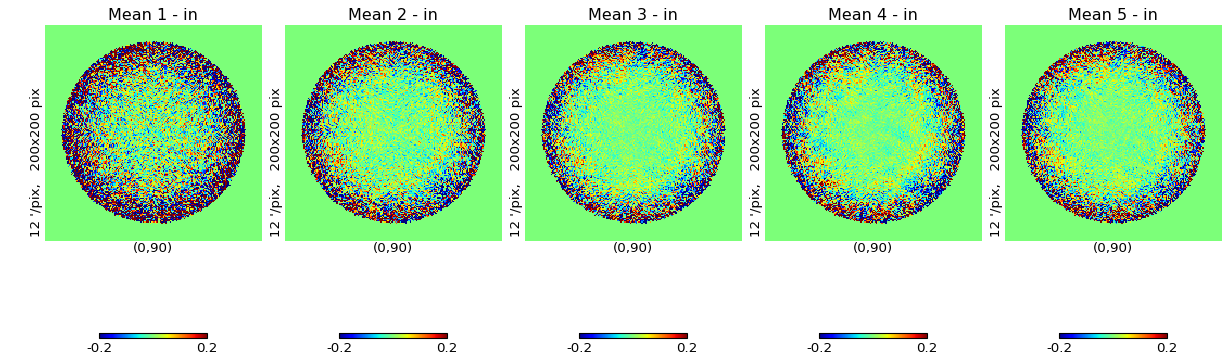

In [343]:
### Now the residuals stupid average (over all sub freqs and MC) 
### with the input calculated for all band
iqu=1
theinput = allmapsin[0][0,0,:,iqu]
rng = 0.2
if iqu==0: rng=10
hp.gnomview(meanmap[0,iqu,:]-theinput, rot=[0,90], reso=12, sub=(1,5,1), title='Mean 1 - in', min=-rng, max=rng)
hp.gnomview(meanmap[1,iqu,:]-theinput, rot=[0,90], reso=12, sub=(1,5,2), title='Mean 2 - in', min=-rng, max=rng)
hp.gnomview(meanmap[2,iqu,:]-theinput, rot=[0,90], reso=12, sub=(1,5,3), title='Mean 3 - in', min=-rng, max=rng)
hp.gnomview(meanmap[3,iqu,:]-theinput, rot=[0,90], reso=12, sub=(1,5,4), title='Mean 4 - in', min=-rng, max=rng)
hp.gnomview(meanmap[4,iqu,:]-theinput, rot=[0,90], reso=12, sub=(1,5,5), title='Mean 5 - in', min=-rng, max=rng)

It looks pretty good but the more sub-frequencies, the more the bias is important

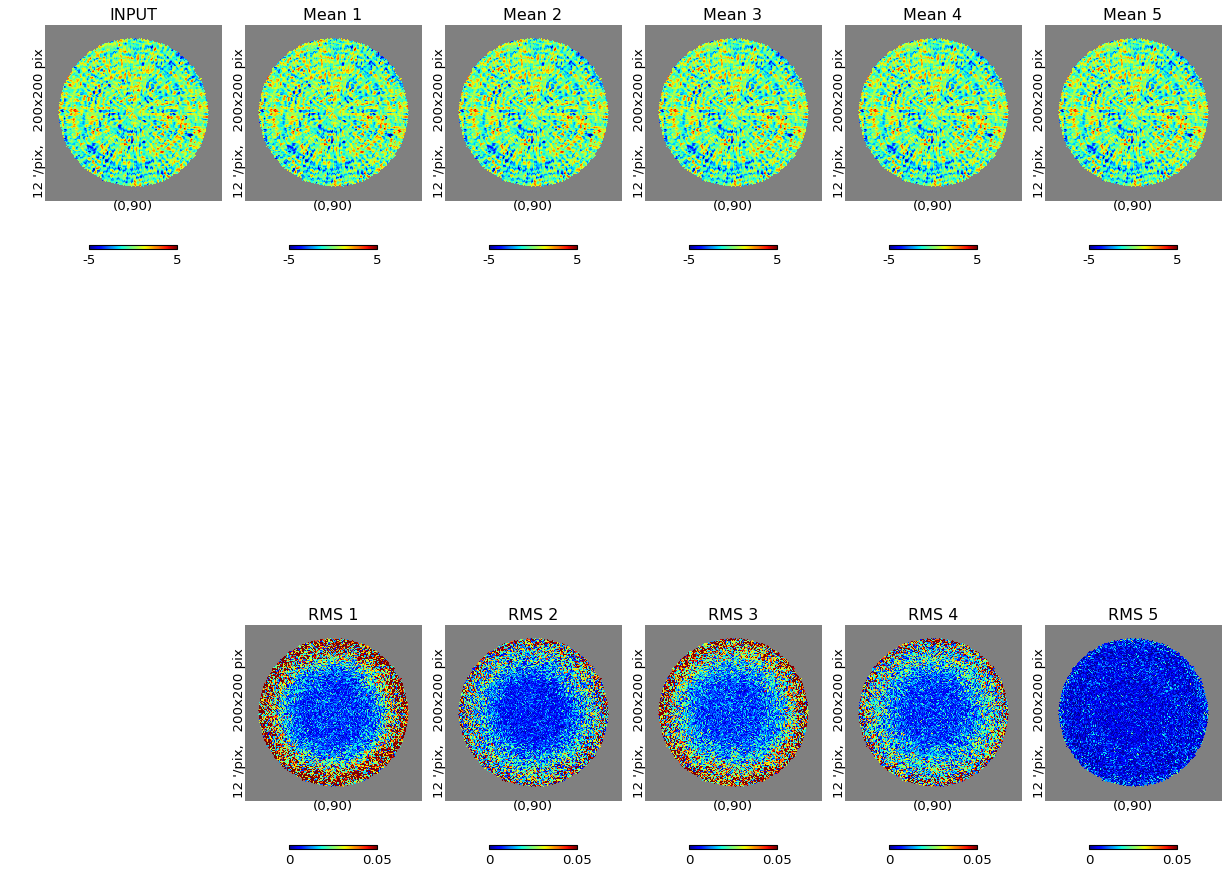

In [341]:
### Just look at the mean and RMS of the above stupid average (over all subfreqs and mc)
iqu=1
rng = 5.
if iqu==0: rng=300.
hp.gnomview(allmapsin[0][0,0,:,iqu], rot=[0,90], reso=12, sub=(2,6,1), title='INPUT', min=-rng, max=rng)
hp.gnomview(meanmap[0,iqu,:], rot=[0,90], reso=12, sub=(2,6,2), title='Mean 1', min=-rng, max=rng)
hp.gnomview(meanmap[1,iqu,:], rot=[0,90], reso=12, sub=(2,6,3), title='Mean 2', min=-rng, max=rng)
hp.gnomview(meanmap[2,iqu,:], rot=[0,90], reso=12, sub=(2,6,4), title='Mean 3', min=-rng, max=rng)
hp.gnomview(meanmap[3,iqu,:], rot=[0,90], reso=12, sub=(2,6,5), title='Mean 4', min=-rng, max=rng)
hp.gnomview(meanmap[4,iqu,:], rot=[0,90], reso=12, sub=(2,6,6), title='Mean 5', min=-rng, max=rng)
hp.gnomview(rmsmap[0,iqu,:], rot=[0,90], reso=12, sub=(2,6,8), title='RMS 1', min=0, max=rng/100)
hp.gnomview(rmsmap[1,iqu,:], rot=[0,90], reso=12, sub=(2,6,9), title='RMS 2', min=0, max=rng/100)
hp.gnomview(rmsmap[2,iqu,:], rot=[0,90], reso=12, sub=(2,6,10), title='RMS 3', min=0, max=rng/100)
hp.gnomview(rmsmap[3,iqu,:], rot=[0,90], reso=12, sub=(2,6,11), title='RMS 4', min=0, max=rng/100)
hp.gnomview(rmsmap[4,iqu,:], rot=[0,90], reso=12, sub=(2,6,12), title='RMS 5', min=0, max=rng/100)

The result is a bit surprizing:
- The averages seem to look very much like the input, which is good
- The RMS maps are weird: the worst seems to be NO Spectro-Imaging and then nothing really makes sense: from 2 to 3 subs noise increases, and then decreases with 4 and is really good with 5.
- the effect is even stronger with 1e-4 than with 5e-5 tolerance

##### Probably it is related to the fact that we did not account for Band-Band covariance matrix - However I would have expected that neglecting the band-band covariance matrix would make results very suboptimal and show a bad reconstruction for nsub > 1

So we need to calculate the band band covariance matrix (for each pixel, and also investigate wether it varies a lot from pixel to pixel, because if not we would have it better by averaging over pixels)


In [318]:
#Now the test done by Matthieu Tristram: 
# calculate the variance map in each case accounting for the band-band covariance matrix 
# for each pixel from the MC. This is pretty noisy so it may be interesting to get the 
# average matrix
# We calculate all the matrices for each pixel and normalize them to 
# avergae 1 and then calculate the average matrix
variance_map = np.zeros((len(nsubvals), 3, 12*nside**2))+hp.UNSEEN
allmeanmat = []
allstdmat = []
for irec in xrange(len(nsubvals)):
    print('doing Nrec={}'.format(nsubvals[irec]))
    allmaps = allmapsout[irec]
    print(allmaps.shape)
    allmat = np.zeros((nsubvals[irec],nsubvals[irec],len(seen), 3))
    for p in xrange(len(seen)):
        for t in [0,1,2]:
            mat = cov(allmaps[:,:,seen[p],t].T)
            allmat[:,:,p,t] = mat#/mean(mat)
            if size(mat) == 1: variance_map[irec,t,p] = mat
            else: variance_map[irec,t,seen[p]] = 1./sum(inv(mat))
    meanmat = np.zeros((nsubvals[irec],nsubvals[irec],3))
    stdmat = np.zeros((nsubvals[irec],nsubvals[irec],3))
    for t in [0,1,2]:
        meanmat[:,:,t] = np.mean(allmat[:,:,:,t], axis=2)
        stdmat[:,:,t] = np.std(allmat[:,:,:,t], axis=2)
    allmeanmat.append(meanmat)
    allstdmat.append(stdmat)
    

doing Nrec=1
(20, 1, 786432, 3)
doing Nrec=2
(20, 2, 786432, 3)
doing Nrec=3
(20, 3, 786432, 3)
doing Nrec=4
(20, 4, 786432, 3)
doing Nrec=5
(20, 5, 786432, 3)


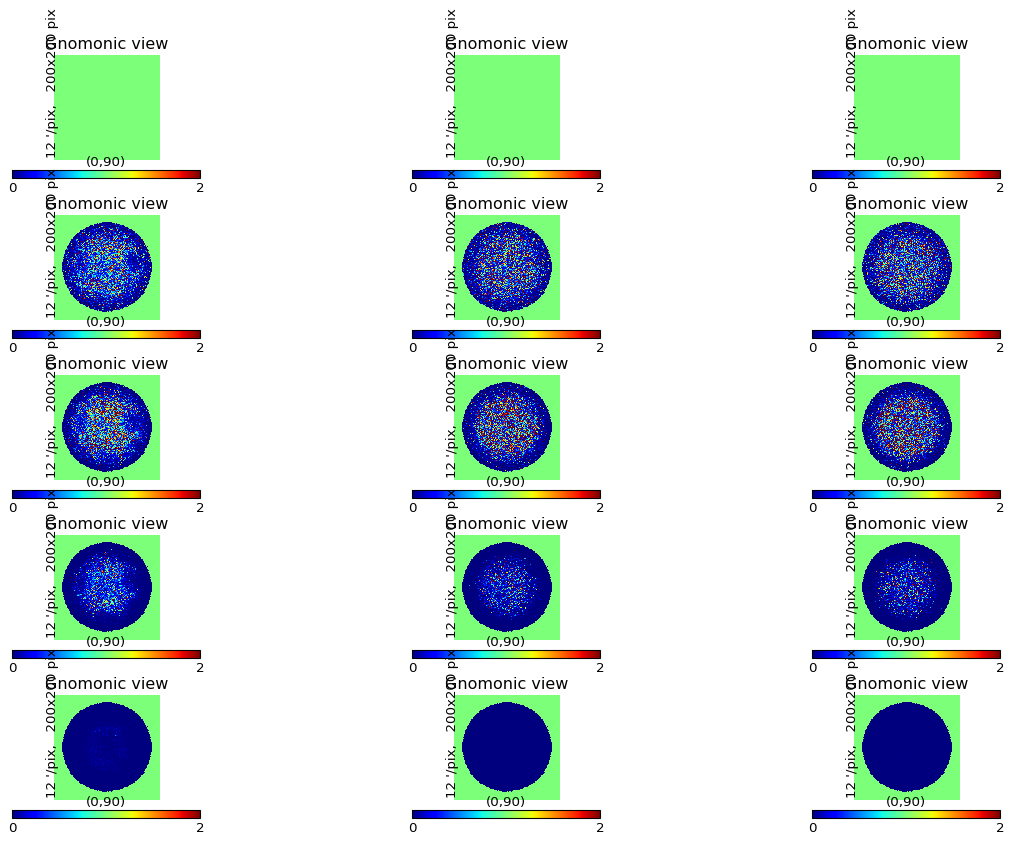

In [319]:
### The variance maps - seems that I don't get consistent results with Matt...
for irec in xrange(len(nsubvals)):
    for t in [0,1,2]:
        hp.gnomview(variance_map[irec,t,:]/variance_map[0,t,:], rot=[0,90], reso=12, 
                    sub=(len(nsubvals),3,irec*3+t+1), min=0, max=2)

In [320]:
print(allmeanmat[3].shape)
for irec in xrange(len(nsubvals)):
    for iqu in [0,1,2]:
        print(mean(allmeanmat[irec][:,:,iqu]))


(4, 4, 3)
0.00590434991988
0.00154231089319
0.00154516149099
0.0020380982936
0.000665553884694
0.000660452126828
0.00362036822421
0.00112321391051
0.00109667363386
0.00200744010531
0.000672488719687
0.000684662161679
0.000188715127543
6.20221128877e-05
6.00095518289e-05


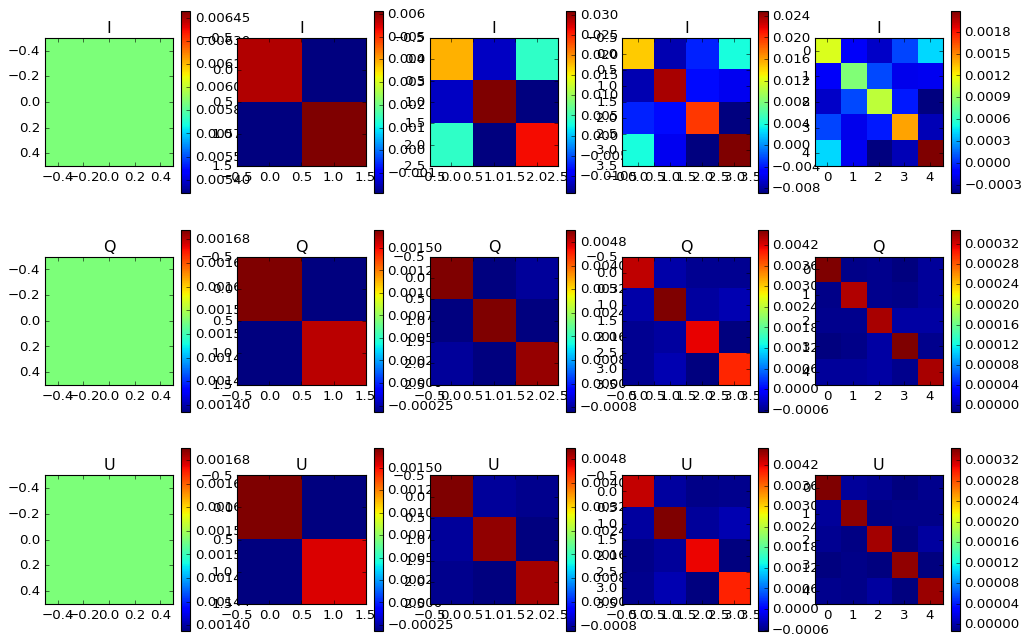

In [321]:
### Let's look at the mean correlation matrices
stokes = ['I', 'Q', 'U']
for irec in xrange(len(nsubvals)):
    for t in [0,1,2]:
        subplot(3,len(nsubvals),len(nsubvals)*t+irec+1)
        imshow(allmeanmat[irec][:,:,t], interpolation='nearest')
        colorbar()
        title(stokes[t])

In [322]:
allmeanmat[2].T

array([[[ 0.01832786, -0.01153616,  0.00427913],
        [-0.01153616,  0.03094612, -0.01424718],
        [ 0.00427913, -0.01424718,  0.02631776]],

       [[ 0.00522124, -0.00095287, -0.00079391],
        [-0.00095287,  0.00521366, -0.00095996],
        [-0.00079391, -0.00095996,  0.00508749]],

       [[ 0.00515525, -0.0007973 , -0.00088091],
        [-0.0007973 ,  0.00503909, -0.00096092],
        [-0.00088091, -0.00096092,  0.00495398]]])

In [323]:
### Npw we want to use these matrices to make the average over freqs for each MC 
### and then look at the mean and RMS. This si likely to be less noisy than calculating
### the variace map with a MC calculated matrix for each pixel.

def mean_cov(vals, invcov):
    AtNid = np.sum(np.dot(invcov, vals))
    AtNiA_inv = 1./np.sum(invcov)
    return AtNid*AtNiA_inv
    
rmsmap_cov = np.zeros((len(nsubvals),3,12*nside**2))+hp.UNSEEN
meanmap_cov = np.zeros((len(nsubvals),3,12*nside**2))+hp.UNSEEN

for i in arange(len(nsubvals)):
    print(i)
    mapsout = allmapsout[i]
    sh = mapsout.shape
    nreals = sh[0]
    for iqu in [0,1,2]:
        covmat = allmeanmat[i][:,:,iqu]
        invcovmat = inv(covmat)
        for p in seen:
            vals = np.zeros(nreals)
            for real in xrange(nreals):
                vals[real] = mean_cov(mapsout[real,:,p,iqu], invcovmat)
            meanmap_cov[i,iqu,p] = np.mean(vals)
            rmsmap_cov[i,iqu,p] = np.std(vals)
            if p<2: print(p,iqu,mapsout[:,:,p,iqu].shape,meanmap_cov[i,iqu,p], rmsmap_cov[i,iqu,p])



0
(0, 0, (20, 1), 38.582143799559191, 0.018931911703031021)
(1, 0, (20, 1), 69.292873264867183, 0.01886391538251566)
(0, 1, (20, 1), 0.31869632966075939, 0.0086504062199558168)
(1, 1, (20, 1), -0.14487451095596898, 0.0074230087072509419)
(0, 2, (20, 1), 1.8901906709073213, 0.0058726133280382646)
(1, 2, (20, 1), -0.17531226388882176, 0.011677947608691019)
1
(0, 0, (20, 2), 40.512069219881461, 0.011528682265916967)
(1, 0, (20, 2), 70.922878795288881, 0.025014593591591017)
(0, 1, (20, 2), 0.27570855219823198, 0.0045044095637418726)
(1, 1, (20, 2), -0.19097223173090649, 0.0077975073198991787)
(0, 2, (20, 2), 1.8251117138029194, 0.0049861432223637413)
(1, 2, (20, 2), -0.17499083479655728, 0.0053735110921890516)
2
(0, 0, (20, 3), 40.697972692190184, 0.0082113502811726625)
(1, 0, (20, 3), 71.034270581973118, 0.020179942326746247)
(0, 1, (20, 3), 0.30783098244635032, 0.0075544431234665409)
(1, 1, (20, 3), -0.16921915356096215, 0.011575000899706846)
(0, 2, (20, 3), 1.8083164498958664, 0.0035896

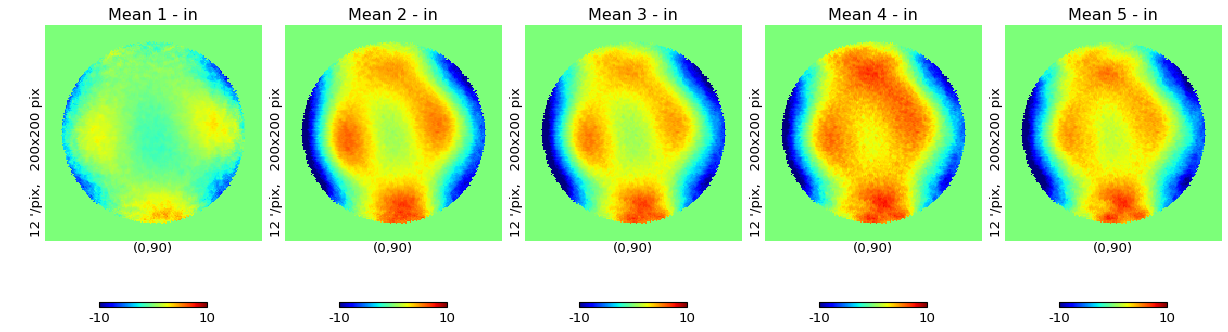

In [324]:
### Now the residuals cov weighted average (over all sub freqs and MC) 
### with the input calculated for all band
iqu=0
theinput = allmapsin[0][0,0,:,iqu]
rng = 0.2
if iqu==0: rng=10
hp.gnomview(meanmap_cov[0,iqu,:]-theinput, rot=[0,90], reso=12, sub=(1,5,1), title='Mean 1 - in', min=-rng, max=rng)
hp.gnomview(meanmap_cov[1,iqu,:]-theinput, rot=[0,90], reso=12, sub=(1,5,2), title='Mean 2 - in', min=-rng, max=rng)
hp.gnomview(meanmap_cov[2,iqu,:]-theinput, rot=[0,90], reso=12, sub=(1,5,3), title='Mean 3 - in', min=-rng, max=rng)
hp.gnomview(meanmap_cov[3,iqu,:]-theinput, rot=[0,90], reso=12, sub=(1,5,4), title='Mean 4 - in', min=-rng, max=rng)
hp.gnomview(meanmap_cov[4,iqu,:]-theinput, rot=[0,90], reso=12, sub=(1,5,5), title='Mean 5 - in', min=-rng, max=rng)


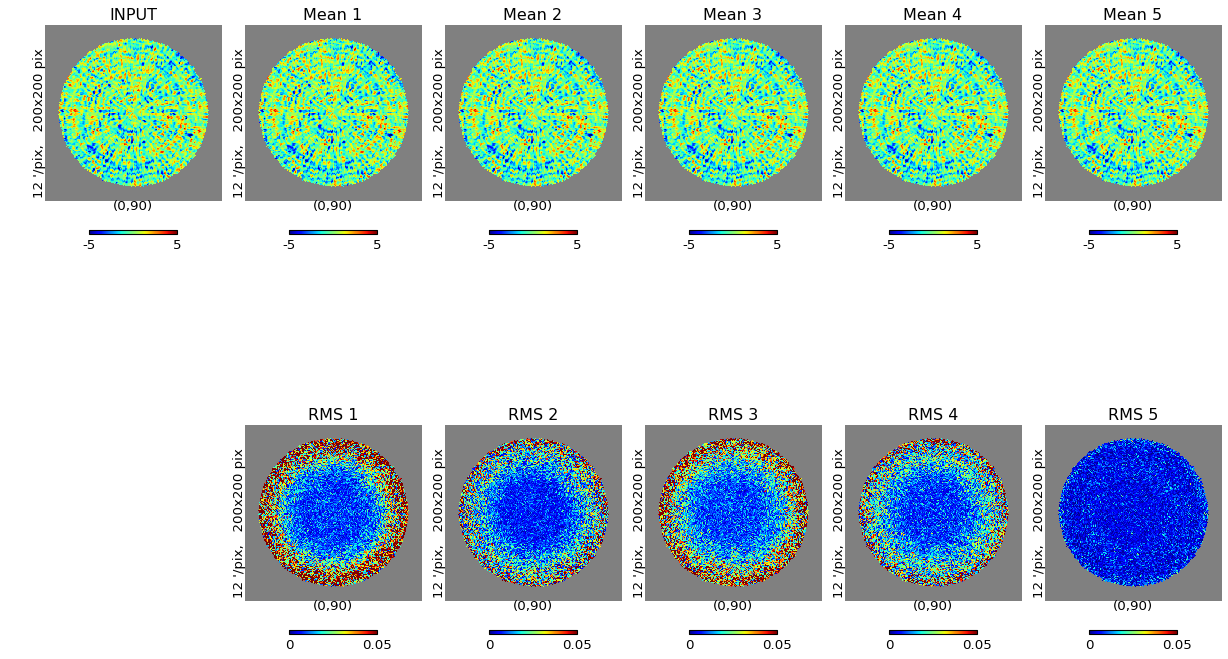

In [325]:
### Just look at the mean and RMS of the above average (over all subfreqs and mc)
iqu=1
rng = 5.
if iqu==0: rng=300.
hp.gnomview(allmapsin[0][0,0,:,iqu], rot=[0,90], reso=12, sub=(2,6,1), title='INPUT', min=-rng, max=rng)
hp.gnomview(meanmap_cov[0,iqu,:], rot=[0,90], reso=12, sub=(2,6,2), title='Mean 1', min=-rng, max=rng)
hp.gnomview(meanmap_cov[1,iqu,:], rot=[0,90], reso=12, sub=(2,6,3), title='Mean 2', min=-rng, max=rng)
hp.gnomview(meanmap_cov[2,iqu,:], rot=[0,90], reso=12, sub=(2,6,4), title='Mean 3', min=-rng, max=rng)
hp.gnomview(meanmap_cov[3,iqu,:], rot=[0,90], reso=12, sub=(2,6,5), title='Mean 4', min=-rng, max=rng)
hp.gnomview(meanmap_cov[4,iqu,:], rot=[0,90], reso=12, sub=(2,6,6), title='Mean 5', min=-rng, max=rng)
hp.gnomview(rmsmap_cov[0,iqu,:], rot=[0,90], reso=12, sub=(2,6,8), title='RMS 1', min=0, max=rng/100)
hp.gnomview(rmsmap_cov[1,iqu,:], rot=[0,90], reso=12, sub=(2,6,9), title='RMS 2', min=0, max=rng/100)
hp.gnomview(rmsmap_cov[2,iqu,:], rot=[0,90], reso=12, sub=(2,6,10), title='RMS 3', min=0, max=rng/100)
hp.gnomview(rmsmap_cov[3,iqu,:], rot=[0,90], reso=12, sub=(2,6,11), title='RMS 4', min=0, max=rng/100)
hp.gnomview(rmsmap_cov[4,iqu,:], rot=[0,90], reso=12, sub=(2,6,12), title='RMS 5', min=0, max=rng/100)

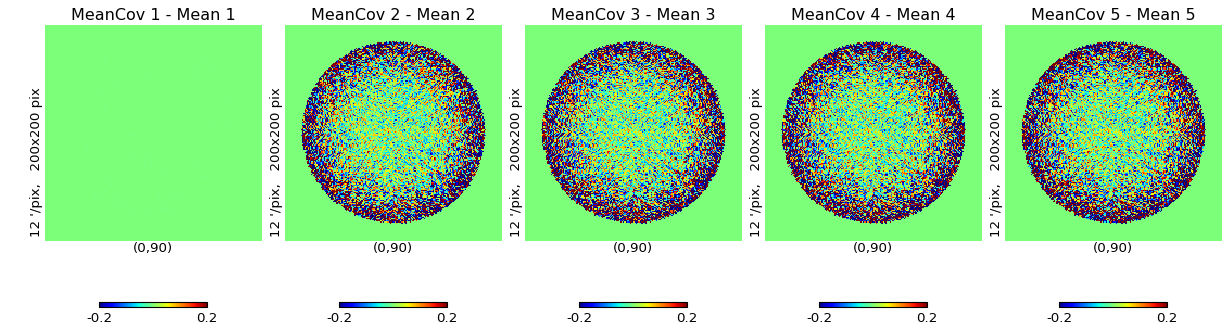

In [327]:
### See How different the maps are w.r.t. stupid average
iqu=1
rng = 0.2
if iqu==0: rng=10
hp.gnomview(meanmap_cov[0,iqu,:]-meanmap[0,iqu,:], rot=[0,90], reso=12, sub=(1,5,1), title='MeanCov 1 - Mean 1', min=-rng, max=rng)
hp.gnomview(meanmap_cov[1,iqu,:]-meanmap[0,iqu,:], rot=[0,90], reso=12, sub=(1,5,2), title='MeanCov 2 - Mean 2', min=-rng, max=rng)
hp.gnomview(meanmap_cov[2,iqu,:]-meanmap[0,iqu,:], rot=[0,90], reso=12, sub=(1,5,3), title='MeanCov 3 - Mean 3', min=-rng, max=rng)
hp.gnomview(meanmap_cov[3,iqu,:]-meanmap[0,iqu,:], rot=[0,90], reso=12, sub=(1,5,4), title='MeanCov 4 - Mean 4', min=-rng, max=rng)
hp.gnomview(meanmap_cov[4,iqu,:]-meanmap[0,iqu,:], rot=[0,90], reso=12, sub=(1,5,5), title='MeanCov 5 - Mean 5', min=-rng, max=rng)

In [328]:
#### Comparison of the residuals between stupid and weighted average
chisqperpix = np.zeros((len(nsubvals), 3))
chisqperpix_cov = np.zeros((len(nsubvals), 3))
for irec in xrange(len(nsubvals)):
    for iqu in [0,1,2]:
        theinput = allmapsin[0][0,0,:,iqu]
        chisqperpix[irec, iqu] = np.sum((meanmap[irec,iqu,seen] - theinput[seen])**2)/len(seen)
        chisqperpix_cov[irec,iqu] = np.sum((meanmap_cov[irec,iqu,seen] - theinput[seen])**2)/len(seen)
print(chisqperpix)
print('')
print(chisqperpix_cov)
print('')
print(chisqperpix_cov/chisqperpix)

[[  2.92897523e+00   5.02306348e-02   5.11295315e-02]
 [  1.58463294e+01   2.31027342e-02   2.42075538e-02]
 [  1.64120677e+01   1.68428650e-02   1.70740813e-02]
 [  1.79473425e+01   1.71760383e-02   1.81637747e-02]
 [  1.78562348e+01   1.65378614e-02   1.68683112e-02]]

[[  2.92897523e+00   5.02306348e-02   5.11295315e-02]
 [  1.64521063e+01   2.27535683e-02   2.36690808e-02]
 [  1.64750171e+01   1.68231386e-02   1.70602394e-02]
 [  1.99486530e+01   1.59224850e-02   1.69895376e-02]
 [  1.72990198e+01   1.66180324e-02   1.70015703e-02]]

[[ 1.          1.          1.        ]
 [ 1.03822822  0.98488638  0.97775599]
 [ 1.00383556  0.9988288   0.99918931]
 [ 1.11151013  0.92701732  0.9353528 ]
 [ 0.96879437  1.00484773  1.00789997]]


(0, 0)


/Users/hamilton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in sqrt
/Users/hamilton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in sqrt
/Users/hamilton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in sqrt


(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)
(3, 0)
(3, 1)
(3, 2)
(4, 0)
(4, 1)
(4, 2)


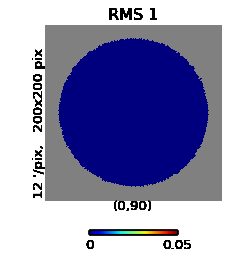

In [329]:
from pysimulators import profile
reso = 12
ally = np.zeros((10,len(nsubvals),3))
ally_cov = np.zeros((10,len(nsubvals),3))
ally_th = np.zeros((10,len(nsubvals),3))
for i in xrange(len(nsubvals)):
    for iqu in [0,1,2]:
        print(i,iqu)
        img = hp.gnomview(rmsmap[i,iqu,:], rot=[0,90], reso=12, sub=(2,6,8), 
                    title='RMS 1', min=0, max=0.05, return_projected_map=True)
        x, y = profile(img**2,bin=10)
        x *= reso *1. / 60
        ally[:,i,iqu] = np.sqrt(y)
    
        img_cov = hp.gnomview(rmsmap_cov[i,iqu,:], rot=[0,90], reso=12, sub=(2,6,8), 
                    title='RMS 1', min=0, max=0.05, return_projected_map=True)
        x, y = profile(img_cov**2,bin=10)
        x *= reso *1. / 60
        ally_cov[:,i,iqu] = np.sqrt(y)

        img_var = hp.gnomview(variance_map[i,iqu,:], rot=[0,90], reso=12, sub=(2,6,8), 
                    title='RMS 1', min=0, max=0.05, return_projected_map=True)
        x, y = profile(img_var,bin=10)
        x *= reso *1. / 60
        ally_th[:,i,iqu] = np.sqrt(y)


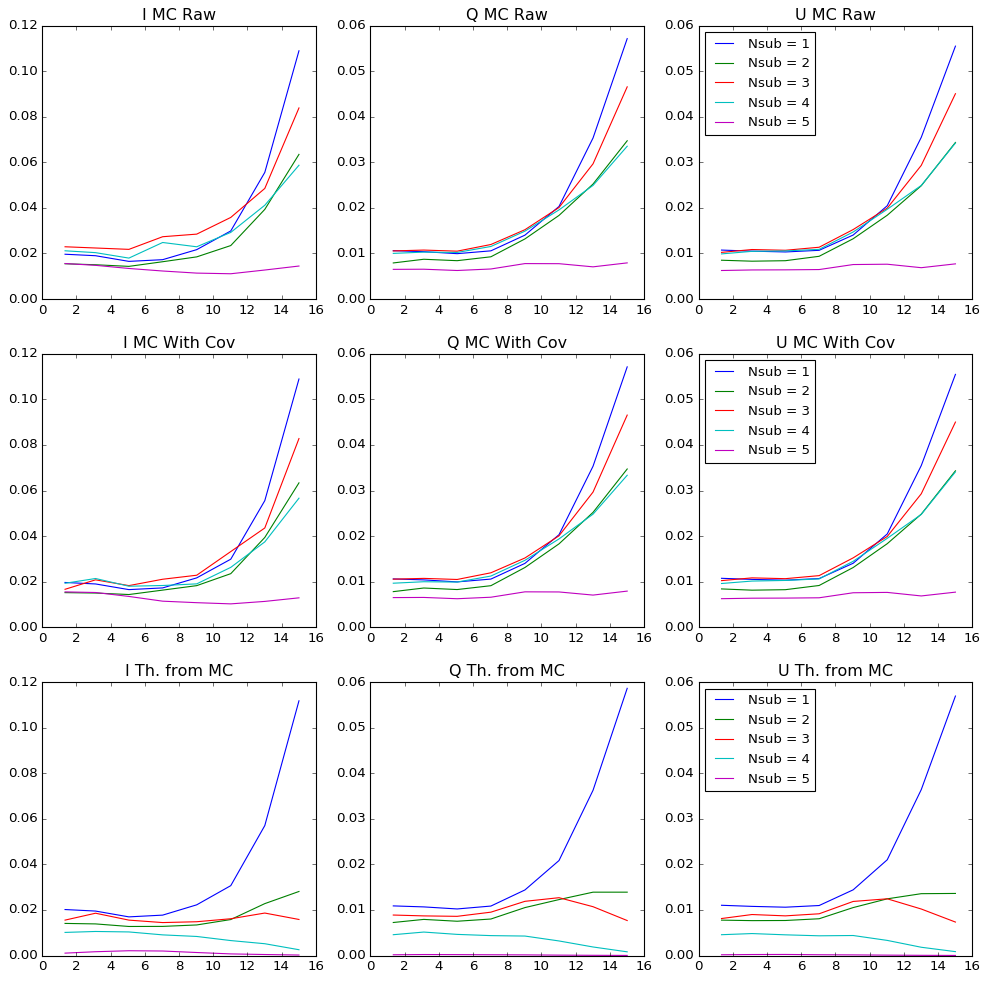

In [342]:
rc('figure',figsize=(15,15))
iqunames = ['I','Q','U']
for i in xrange(len(nsubvals)):
    for iqu in [0,1,2]:
        subplot(3,3,iqu+1)
        plot(x, ally[:,i,iqu], label='Nsub = {}'.format(i+1))
        if i==0: title(iqunames[iqu]+' MC Raw')
legend(fontsize=12, loc='upper left')
for i in xrange(len(nsubvals)):
    for iqu in [0,1,2]:
        subplot(3,3,iqu+1+3)
        plot(x, ally_cov[:,i,iqu], label='Nsub = {}'.format(i+1))
        if i==0: title(iqunames[iqu]+' MC With Cov')
legend(fontsize=12, loc='upper left')
for i in xrange(len(nsubvals)):
    for iqu in [0,1,2]:
        subplot(3,3,iqu+1+6)
        plot(x, ally_th[:,i,iqu], label='Nsub = {}'.format(i+1))
        if i==0: title(iqunames[iqu]+' Th. from MC')
legend(fontsize=12, loc='upper left')